In [ ]:
from __future__ import print_function, division

import os
import sys
import time
import glob
import random
import numpy as np
import pandas as pd

from skimage import io, transform
from PIL import Image
from tqdm import tqdm
from datetime import datetime
import argparse
from bisect import bisect_right, bisect_left

import shutil
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms, utils
import torchvision.transforms as transforms
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models
import torch.optim as optim

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

plt.ion()   # interactive mode

# Import data

In [ ]:
## Here some functions used in the dataprocessing 

In [3]:
def return_idx(timestamps, data):
    "Return the idx of the timestamp of the camera"
    
    idx_sensor = []
    for temp in timestamps:
        idx=int(data[data['timestamp']==temp].index[0])
        idx_sensor.append(idx)
    return idx_sensor


def return_idx_single(temp, data):
    "Return the idx of the timestamp of the camera"
    
    idx_sensor = []
    idx = data[data['timestamp']==temp].index[0]

    return idx

### Import csv data from folders

## Create Dataset and Datalader

In [1]:
imu_data = pd.read_csv('/home/francesca/euroc12/imu0/dadata = pd.read_csv('/home/francesca/euroc12/cam0/daata = pd.read_csv('/home/francesca/euroc12/vicon0/op the first row of the camera
camera_data=camera_data.drop(cmera_data.index[[0]])

# re-assign name to columns
vicon_data.columns = ['timestam','px','py','pz','qw','qx','qy','qz']
camera_data.columns = ['timestamp','filename']
imu_data.columns =['timestamp','wx','wy','wz','ax','ay','az']

# Get the timestamp of the camera and drop the index
camera_timestamps = camera_data['timestamp']
camera_timestamps = camera_timestamps.reset_index(drop=True)

### Interpolate Vicon data to get data at the same timestamp of the camera and IMU
# Vicon data
vicondata = vicon_data.copy() #create a copy

for i in range(len(camera_timestamps)):
    new_row=pd.DataFrame([[camera_timestamps[i],np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]], columns = ['timestamp','px','py','pz','qw','qx','qy','qz'])
    vicondata = pd.concat([vicondata, pd.DataFrame(new_row)], ignore_index=True)
    
vicondata.sort_values(by=['timestamp'],inplace=True, ascending=True)
vicondata = vicondata.reset_index(drop = True)
vicondata = vicondata.interpolate()

# Create a new vicon dataframe with the same timestamps of the camera
idx_vicon=return_idx(camera_timestamps,vicondata)
new_vicon = vicondata.ix[idx_vicon].reset_index(drop=True)

vicon_timestamp = new_vicon['timestamp'].values

# Create a new vicon dataframe with the same timestamps of the camera
idx_vicon=return_idx(camera_timestamps,vicondata)
new_vicon = vicondata.ix[idx_vicon].reset_index(drop=True)

vicon_timestamp = new_vicon['timestamp'].values

# Create a new IMU dataframe with the same timestamps of the camera
idx_imu = return_idx(camera_timestamps, imu_data)
new_imu = imu_data.ix[idx_imu].reset_index(drop=True)
imu_timestamp = new_imu['timestamp'].values

# Create new dataframe for images and save it
image_data = pd.merge(camera_data,new_vicon, on='timestamp').reset_index(drop=True)
image_data.to_csv('euroc12/cam0/image_data.csv',index = None, header=True)

file = pd.read_csv('euroc12/cam0/image_data.csv')
file.drop(file.tail(13).index,inplace=True) # drop last n rows
file.to_csv('euroc12/cam0/file.csv',index = None, header=True)


img_name = file.iloc[:, 1]
labels = file.iloc[:, 2:].as_matrix()

c_t = np.array(camera_timestamps)
new_imu_values = np.zeros((len(c_t),10,7))

# Create a new IMU dataframe with the same timestamps of the camera
for i in range(len(c_t)):
    idx_imu = return_idx_single(camera_timestamps.iloc[i], imu_data)
    new_imu_values[i][:][:] = imu_data.ix[idx_imu:idx_imu+9].reset_index(drop=True).values


new_imu_values = new_imu_values[:1696]

# Create new dataframe for images and save it

image_data = pd.merge(camera_data,new_vicon, on='timestamp').reset_index(drop=True)
image_data.to_csv(r'/home/francesca/euroc12/cam0/imag_data.csv',index = None, header=True)

NameError: name 'pd' is not defined

In [257]:
class NewDataset(Dataset):
    def __init__(self, csv_file, imu_data, root_dir):       
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.frame = pd.read_csv(csv_file)
        self.imu_data = imu_data
        # Second - 7th columns contains the angular rate and acceleration
        self.imu_arr = self.imu_data[:,:,1:]

        # Second column contains the image name
        self.image_arr = np.asarray(self.frame.iloc[:, 1])
        self.label_arr = np.asarray(self.frame.iloc[:, 2:])
        self.root_dir = root_dir
        # Transforms
        transformation = transforms.Compose([
            transforms.Resize(64),
            transforms.CenterCrop((64,96)),
            transforms.ToTensor(),
            transforms.Normalize([0.4543, 0.4543, 0.4543],[0.3035, 0.3035, 0.3035])
        ])
        self.transform = transformation
        # Calculate len
        self.data_len = len(self.frame.index)
        transform_imu = transforms.Compose([
            transforms.ToTensor(),
        ])
        self.transform_imu = transform_imu
    def __len__(self):
        return self.data_len
    
    def __getitem__(self, idx):
        single_image_name = self.image_arr[idx]
        fp = self.root_dir
        # Open image
        image = Image.open(fp + single_image_name).convert('RGB')
        image = self.transform(image)
        imu_data = self.imu_arr[idx]
        # Get label of the image based on the cropped pandas column
        labels = self.label_arr[idx]

        return image, imu_data, labels

In [258]:
dataset = NewDataset(csv_file='euroc12/cam0/file.csv', 
                         imu_data=new_imu_values,
                           root_dir='euroc12/cam0/data/')

dataloader = DataLoader(dataset, batch_size=32,
                        shuffle=False, num_workers=15)

In [261]:
batch_size = 32
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
# split = 320
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader_1 = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

## The network Model

In [264]:
def quaternion_angular_error(q1, q2):
    """
    angular error between two quaternions
    :param q1: (4, )
    :param q2: (4, )
    :return:
    """
    d = abs(np.dot(q1, q2))
    abs_q1 = np.linalg.norm(q1)
    abs_q2 = np.linalg.norm(q2)
    d = d / (abs_q1 * abs_q2)
    d = min(1.0, max(-1.0, d))
    theta = 2 * np.arccos(d) * 180 / np.pi
    return theta

In [266]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1, 1, 1)


class FlattenIMU(nn.Module):
    def forward(self, input):
        return input.view(32, -1)

class IMUNet(torch.nn.Module):
    
    def __init__(self, feature_extractor, num_features=128, dropout=0.5,
                 track_running_stats=False, pretrained=False):
        super(IMUNet, self).__init__()
        self.dropout = dropout
        self.feature_extractor = feature_extractor
        self.feature_extractor.avgpool = torch.nn.AdaptiveAvgPool2d(1)
        fc_in_features = self.feature_extractor.fc.in_features
        
        
        self.IMU_fc = nn.Sequential(
            Flatten(),
            nn.Linear(7, 1024),
            nn.ReLU(),
            nn.Linear(1024, 32),
            nn.ReLU(),
            FlattenIMU()
        )
        
        self.rnn = torch.nn.LSTM(
            input_size=6, 
            hidden_size= 64*2, 
            num_layers=4,
            batch_first=True)
        
        self.flat_imu = FlattenIMU()
        self.linear = nn.Linear(128,num_features)

        self.fc3 = torch.nn.Linear( 4096, num_features)
        self.feature_extractor.fc = torch.nn.Linear(fc_in_features, num_features)
        # Translation
        self.fc_xyz = torch.nn.Linear(num_features, 3)

        # Rotation in quaternions
        self.fc_quat = torch.nn.Linear(num_features, 4)
        
    def extract_features(self, image):
        x_features = self.feature_extractor(image)
        x_features = F.relu(x_features)
        if self.dropout > 0:
            x_features = F.dropout(x_features, p=self.dropout, training=self.training)
        return x_features
    
    def forward(self, data_input):
        image = data_input[0].cuda()
        imu_data = data_input[1].type(torch.FloatTensor).cuda()
        #Images
        if type(image) is list:
            x_features = [self.extract_features(xi) for xi in image]
        elif torch.is_tensor(image):
            x_features = self.extract_features(image)
            
        imu_feat = imu_data
        r_out, (h_n, h_c) = self.rnn(imu_feat)
        imu_out = self.linear(r_out[:, -1, :]) # we want just the last time 


        imu_out = self.flat_imu(imu_out) # we want just the last time 
    
        x = torch.cat((x_features, imu_out), dim=1)
        x = F.relu(self.fc3(x))

        if type(x) is list:
            x_translations = [self.fc_xyz(xi) for xi in x]
            x_rotations = [self.fc_quat(xi) for xi in x]
            x_poses = [torch.cat((xt, xr), dim=1) for xt, xr in zip(x_translations, x_rotations)]  
        elif torch.is_tensor(x):
            x_translations = self.fc_xyz(x) 
            x_rotations = self.fc_quat(x)
            x_poses = torch.cat((x_translations, x_rotations), dim=1)

        return x_poses

class AverageMeter():
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, value, n=1):
        self.val = value
        self.count += n
        self.sum += value * n
        self.avg = self.sum / self.count

## The Loss Criterion

In [267]:
# set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create pretrained feature extractor
feature_extractor = models.resnet18(pretrained=True)

# Num features for the last layer before pose regressor
num_features = 2048

# Create model
model = IMUNet(feature_extractor, num_features=num_features, pretrained=True)
model = model.to(device)


# Create pretrained feature extractor
feature_extractor = models.resnet18(pretrained=True)

In [3]:
### Training and Validatin functions

In [276]:
class NetCriterion(torch.nn.Module):
    def __init__(self, beta = 512.0, learn_beta=True, sx=0.0, sq=1.0):
        super(NetCriterion, self).__init__()
        self.loss_fn1 = torch.nn.L1Loss()
        self.loss_fn = torch.nn.MSELoss()
        self.learn_beta = learn_beta
        if not learn_beta:
            self.beta = beta
        else:
            self.beta = 1.0
        self.sx = torch.nn.Parameter(torch.Tensor([sx]), requires_grad=learn_beta)
        self.sq = torch.nn.Parameter(torch.Tensor([sq]), requires_grad=learn_beta)

    def forward(self, x, y):
        """
        Args:
            x: list(N x 7, N x 7) - prediction (xyz, quat)
            y: list(N x 7, N x 7) - target (xyz, quat)
        """
        
        loss = 0
        # Translation loss
        loss = torch.exp(-self.sx) * (self.loss_fn(x[:, :3], y[:, :3])+0.01*self.loss_fn1(x[:, :3], y[:, :3])) 
        # Rotation loss
        loss += torch.exp(-self.sq) * self.beta * self.loss_fn(x[:, 3:], y[:, 3:]+0.01*self.loss_fn1(x[:, 3:], y[:, 3:])) + self.sq

        return loss

## Train the network

In [279]:
def train(train_loader, model, criterion, optimizer, epoch, max_epoch, log_freq=1, print_sum=True):
    
    position_loss=[]
    orientation_loss = []
    
    model.train()
    losses = AverageMeter()
    epoch_time = time.time()
    
    gt_poses = np.empty((0, 7))
    pred_poses = np.empty((0, 7))
    
    end = time.time()
    
    for idx, data in enumerate(train_loader):
        if idx == 1920:
            idx = 1919
        batch_images= data[0].cuda()
        imu_data= data[1].unsqueeze(0).cuda()
    
        batch_poses= data[2].cuda()
        data_time = (time.time() - end)
        batch_images = batch_images.to(device)
        batch_poses = batch_poses.to(device)
        batch_poses = torch.tensor(batch_poses, dtype=torch.float, device=device)
        imu_data = torch.tensor(imu_data, dtype=torch.float, device=device)

        out = model(data[0:2])
        loss = criterion(out, batch_poses)
        
        # Training step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.update(loss.data[0], len(batch_images) * batch_images.size(0))
        
        
        # move data to cpu & numpy
        bp = batch_poses.detach().cpu().numpy()
        outp = out.detach().cpu().numpy()
        gt_poses = np.vstack((gt_poses, bp))
        pred_poses = np.vstack((pred_poses, outp))
        
        batch_time = (time.time() - end)
        end = time.time()
        
        if log_freq != 0 and idx % log_freq == 0:
            print('Epoch: [{}/{}]\tBatch: [{}/{}]\t'
                  'Time: {batch_time:.3f}\t'
                  'Data Time: {data_time:.3f}\t'
                  'Loss: {losses.val:.3f}\t'
                  'Avg Loss: {losses.avg:.3f}\t'.format(
                   epoch, max_epoch - 1, idx, len(train_loader) - 1,
                   batch_time=batch_time, data_time=data_time, losses=losses))
            
        t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
        q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])
    position_loss.append(t_loss)
    orientation_loss.append(q_loss)
        
    return losses
    
def validate(val_loader, model, criterion, epoch, log_freq=1, print_sum=True):
    
    losses = AverageMeter()
    position_loss_testing=[]
    orientation_loss_testing=[]
    
    # set model to evaluation
    model.eval()
    
    with torch.no_grad():
        epoch_time = time.time()
        end = time.time()
        for idx, data in enumerate(val_loader):


            batch_images= data[0].cuda()
            imu_data= data[1].cuda()
        
            batch_poses= data[2].cuda()
            data_time = time.time() - end
            
            batch_images = batch_images.to(device)
            batch_poses = batch_poses.to(device)
            batch_poses = torch.tensor(batch_poses, dtype=torch.float, device=device)
            imu_data = imu_data.to(device)
            imu_data = torch.tensor(imu_data, dtype=torch.float, device=device)

            # compute model output
            out = model(data[:2])
            loss = criterion(out, batch_poses)
            
            losses.update(loss.data[0], len(data[0]) * data[0].size(0))
            batch_time = time.time() - end
            end = time.time()
            if log_freq != 0 and idx % log_freq == 0:
                print('Val Epoch: {}\t'
                      'Time: {batch_time:.3f}\t'
                      'Data Time: {data_time:.3f}\t'
                      'Loss: {losses.val:.3f}\t'
                      'Avg Loss: {losses.avg:.3f}'.format(
                       epoch, batch_time=batch_time, data_time=data_time, losses=losses))

    return losses


## Let's plot the results! 

In [288]:
imu = next(iter(train_loader))[1]
# Create model
model = IMUNet(feature_extractor, num_features=num_features, pretrained=True)
model = model.to(device)

# Criterion
criterion = NetCriterion(learn_beta=True)
criterion = criterion.to(device)

# Add all params for optimization
param_list = [{'params': model.parameters()}]
if criterion.learn_beta:
    param_list.append({'params': criterion.parameters()})

# Create optimizer
# optimizer = optim.Adam(params=param_list, lr=1e-5, weight_decay=0.0005)
optimizer = optim.Adam(params=param_list, lr=0.0001, weight_decay=0.0001)


# Epochs to train
start_epoch = 0
n_epochs = 10

train_loss=[]
test_loss=[]
print('Training ...')
val_freq = 10
for e in range(start_epoch, n_epochs):
    losses = train(train_loader, model, criterion, optimizer, e, n_epochs, log_freq=100)
    train_loss.append(losses)
    if losses.val <= 0:
        break
    if e % val_freq == 0:
        loss = validate(validation_loader, model, criterion, e, log_freq=100)
        test_loss.append(loss)

torch.save(model, 'LSTM_pos_workin2_v2.torch')
print('n_epochs = {}'.format(n_epochs))



Training ...
Epoch: [0/619]	Batch: [0/42]	Time: 0.331	Data Time: 0.221	Loss: 3.353	Avg Loss: 3.353	
Val Epoch: 0	Time: 0.251	Data Time: 0.186	Loss: 1.148	Avg Loss: 1.148
Epoch: [1/619]	Batch: [0/42]	Time: 0.289	Data Time: 0.174	Loss: 1.191	Avg Loss: 1.191	
Epoch: [2/619]	Batch: [0/42]	Time: 0.275	Data Time: 0.176	Loss: 1.090	Avg Loss: 1.090	
Epoch: [3/619]	Batch: [0/42]	Time: 0.274	Data Time: 0.178	Loss: 1.075	Avg Loss: 1.075	
Epoch: [4/619]	Batch: [0/42]	Time: 0.292	Data Time: 0.181	Loss: 1.038	Avg Loss: 1.038	
Epoch: [5/619]	Batch: [0/42]	Time: 0.296	Data Time: 0.185	Loss: 1.026	Avg Loss: 1.026	
Epoch: [6/619]	Batch: [0/42]	Time: 0.314	Data Time: 0.190	Loss: 1.021	Avg Loss: 1.021	
Epoch: [7/619]	Batch: [0/42]	Time: 0.343	Data Time: 0.203	Loss: 1.020	Avg Loss: 1.020	
Epoch: [8/619]	Batch: [0/42]	Time: 0.306	Data Time: 0.177	Loss: 1.027	Avg Loss: 1.027	
Epoch: [9/619]	Batch: [0/42]	Time: 0.289	Data Time: 0.178	Loss: 0.988	Avg Loss: 0.988	
Epoch: [10/619]	Batch: [0/42]	Time: 0.275	Data 

Epoch: [86/619]	Batch: [0/42]	Time: 0.285	Data Time: 0.173	Loss: 0.636	Avg Loss: 0.636	
Epoch: [87/619]	Batch: [0/42]	Time: 0.289	Data Time: 0.187	Loss: 0.629	Avg Loss: 0.629	
Epoch: [88/619]	Batch: [0/42]	Time: 0.310	Data Time: 0.186	Loss: 0.626	Avg Loss: 0.626	
Epoch: [89/619]	Batch: [0/42]	Time: 0.312	Data Time: 0.184	Loss: 0.622	Avg Loss: 0.622	
Epoch: [90/619]	Batch: [0/42]	Time: 0.271	Data Time: 0.172	Loss: 0.618	Avg Loss: 0.618	
Val Epoch: 90	Time: 0.273	Data Time: 0.181	Loss: 0.611	Avg Loss: 0.611
Epoch: [91/619]	Batch: [0/42]	Time: 0.312	Data Time: 0.186	Loss: 0.613	Avg Loss: 0.613	
Epoch: [92/619]	Batch: [0/42]	Time: 0.297	Data Time: 0.179	Loss: 0.609	Avg Loss: 0.609	
Epoch: [93/619]	Batch: [0/42]	Time: 0.323	Data Time: 0.180	Loss: 0.609	Avg Loss: 0.609	
Epoch: [94/619]	Batch: [0/42]	Time: 0.328	Data Time: 0.177	Loss: 0.601	Avg Loss: 0.601	
Epoch: [95/619]	Batch: [0/42]	Time: 0.295	Data Time: 0.176	Loss: 0.596	Avg Loss: 0.596	
Epoch: [96/619]	Batch: [0/42]	Time: 0.317	Data Ti

Epoch: [171/619]	Batch: [0/42]	Time: 0.328	Data Time: 0.184	Loss: 0.266	Avg Loss: 0.266	
Epoch: [172/619]	Batch: [0/42]	Time: 0.326	Data Time: 0.180	Loss: 0.263	Avg Loss: 0.263	
Epoch: [173/619]	Batch: [0/42]	Time: 0.320	Data Time: 0.196	Loss: 0.259	Avg Loss: 0.259	
Epoch: [174/619]	Batch: [0/42]	Time: 0.326	Data Time: 0.181	Loss: 0.254	Avg Loss: 0.254	
Epoch: [175/619]	Batch: [0/42]	Time: 0.278	Data Time: 0.176	Loss: 0.249	Avg Loss: 0.249	
Epoch: [176/619]	Batch: [0/42]	Time: 0.308	Data Time: 0.176	Loss: 0.246	Avg Loss: 0.246	
Epoch: [177/619]	Batch: [0/42]	Time: 0.318	Data Time: 0.180	Loss: 0.241	Avg Loss: 0.241	
Epoch: [178/619]	Batch: [0/42]	Time: 0.299	Data Time: 0.183	Loss: 0.237	Avg Loss: 0.237	
Epoch: [179/619]	Batch: [0/42]	Time: 0.323	Data Time: 0.184	Loss: 0.234	Avg Loss: 0.234	
Epoch: [180/619]	Batch: [0/42]	Time: 0.322	Data Time: 0.188	Loss: 0.229	Avg Loss: 0.229	
Val Epoch: 180	Time: 0.262	Data Time: 0.188	Loss: 0.223	Avg Loss: 0.223
Epoch: [181/619]	Batch: [0/42]	Time: 0

In [292]:
def model_results_pred_gt(model, dataloader):
    
    model.eval()

    gt_poses = np.empty((0, 7))
    pred_poses = np.empty((0, 7))

    for idx, data in enumerate(dataloader):
        batch_images = data[0].cuda()
        batch_imu = data[1].cuda()
        batch_poses  = data[2].cuda()
        batch_images = batch_images.to(device)
        batch_imu = batch_imu.to(device)
        batch_imu = torch.tensor(batch_imu, dtype=torch.float, device=device)
        batch_poses = batch_poses.to(device)
        batch_poses = torch.tensor(batch_poses, dtype=torch.float, device=device)
        out = model(data[0:2])        
        loss = criterion(out, batch_poses)
        bp = batch_poses.detach().cpu().numpy()
        outp = out.detach().cpu().numpy()
        gt_poses = np.vstack((gt_poses, bp))
        pred_poses = np.vstack((pred_poses, outp))

    gt_poses[:, :3] = gt_poses[:, :3] 
    pred_poses[:, :3] = pred_poses[:, :3] 
    
    return pred_poses, gt_poses

print('\n=== Test Training Dataset ======')
pred_poses, gt_poses = model_results_pred_gt(model, train_loader)

print('gt_poses = {}'.format(gt_poses.shape))
print('pred_poses = {}'.format(pred_poses.shape))
t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

print('Translation(T) error in meters and Rotation(R) error in degrees:')
print('T: median = {:.3f}, mean = {:.3f}'.format(np.median(t_loss), np.mean(t_loss)))
print('R: median = {:.3f}, mean = {:.3f}'.format(np.median(q_loss), np.mean(q_loss)))

# Save for later visualization
pred_poses_train = pred_poses
gt_poses_train = gt_poses



=== Test Training Dataset ======
gt_poses = (1376, 7)
pred_poses = (1376, 7)
Translation(T) error in meters and Rotation(R) error in degrees:
T: median = 0.075, mean = 0.085
R: median = 3.933, mean = 4.604


In [293]:
print('\n=== Test Validation Dataset ======')
pred_poses, gt_poses = model_results_pred_gt(model, validation_loader)

print('gt_poses = {}'.format(gt_poses.shape))
print('pred_poses = {}'.format(pred_poses.shape))
t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

print('Translation(T) error in meters and Rotation(R) error in degrees:')
print('T: median = {:.3f}, mean = {:.3f}'.format(np.median(t_loss), np.mean(t_loss)))
print('R: median = {:.3f}, mean = {:.3f}'.format(np.median(q_loss), np.mean(q_loss)))

# Save for later visualization
pred_poses_val = pred_poses
gt_poses_val = gt_poses


=== Test Validation Dataset ======
gt_poses = (320, 7)
pred_poses = (320, 7)
Translation(T) error in meters and Rotation(R) error in degrees:
T: median = 0.057, mean = 0.078
R: median = 3.240, mean = 4.024


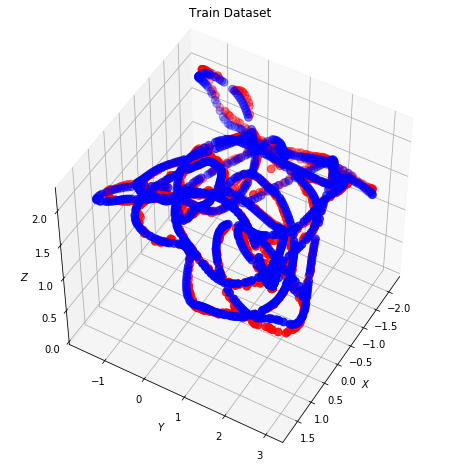

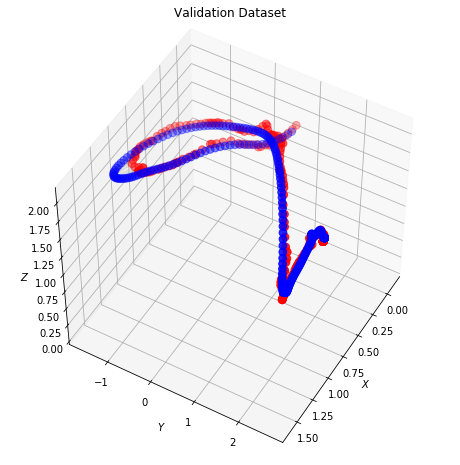

In [294]:
from mpl_toolkits.mplot3d import Axes3D

def calc_poses_params(poses, pose_format='full-mat'):
    """Calculates min, max, mean and std of translations of the poses"""

    p = poses[0]
    allp = extract_translation(p, pose_format)

    for p in poses[1:]:
        allp = np.vstack((allp, extract_translation(p, pose_format)))

    p_min = np.min(allp, axis=0)
    p_max = np.max(allp, axis=0)
    p_mean = np.mean(allp, axis=0)
    p_std = np.std(allp, axis=0)

    return p_min, p_max, p_mean, p_std

def set_3d_axes_limits(ax, poses, pose_format='quat'):
    p_min, p_max, p_mean, p_std = calc_poses_params(poses, pose_format=pose_format)
    ax.set_xlim(p_min[0], p_max[0])
    ax.set_ylim(p_min[1], p_max[1])
    ax.set_zlim(int(p_min[2] - 1), p_max[2])
    return p_min, p_max, p_mean, p_std

def extract_translation(p, pose_format='full-mat'):
    if pose_format == 'full-mat':
        return p[0:3, 3]
    elif pose_format == 'quat':
        return p[:3]
    else:
        warnings.warn("pose_format should be either 'full-mat' or 'quat'")
        return p


def draw_pred_gt_poses(pred_poses, gt_poses):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection='3d')

    ax.set_xlabel('$X$ m')
    ax.set_ylabel('$Y$ m')
    ax.set_zlabel('$Z$ m')
    ax.view_init(50, 30)

    all_poses = np.concatenate((pred_poses, gt_poses))
    p_min, _, _, _ = set_3d_axes_limits(ax, all_poses, pose_format='quat')
    
    draw_poses(ax, pred_poses[:, :3], proj=False, proj_z=int(p_min[2] - 1), c='r', s=60)
    draw_poses(ax, gt_poses[:, :3], proj=False, proj_z=int(p_min[2] - 1), c='b', s=60)
    for i in range(pred_poses.shape[0]):
        pp = pred_poses[i, :3]
        gp = gt_poses[i, :3]
        pps = np.vstack((pp, gp))
        ax.plot(pps[:, 0], pps[:, 1], pps[:, 2], c=(0.7, 0.7, 0.7, 0.4))
        
    plt.draw()
    
def draw_poses(ax, poses, c='b', s=20, proj=False, proj_z=0, pose_format='quat'):
    coords = np.zeros((len(poses), 3))
    for i, p in enumerate(poses):
        coords[i] = extract_translation(p, pose_format=pose_format)

    # Draw projection
    if proj:
        if len(poses) > 1:
            ax.plot(coords[:, 0], coords[:, 1], proj_z, c='g')
        elif len(poses) == 1:
            ax.scatter(coords[:, 0], coords[:, 1], proj_z, c=c)

    # Draw path
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c=c, s=s)


def draw_poses_list(ax, poses_list):
    """Draw list of lists of poses."""
    for poses in poses_list:
        draw_poses(ax, poses)

draw_pred_gt_poses(pred_poses_train, gt_poses_train)
plt.title('Train Dataset')
plt.show()


draw_pred_gt_poses(pred_poses_val, gt_poses_val)
plt.title('Validation Dataset')
plt.show()